Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [2]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [4]:
plt.rcParams["font.size"] = 18

In [5]:
# Set Seed
SEED = 123
numpy.random.seed(SEED)

rand_perm = []
for i in range(1,6):
    size = signal['signal'+str(i)].shape[1]
    print(f'Mouse{i}: Number of measurements is {size}.')
    rand = numpy.random.permutation(signal['signal'+str(i)].shape[1])
    rand_perm.append(rand)

Mouse1: Number of measurements is 11.
Mouse2: Number of measurements is 12.
Mouse3: Number of measurements is 14.
Mouse4: Number of measurements is 15.
Mouse5: Number of measurements is 12.


In [6]:
# Random assignment of label data for each measurement
rand_perm

[array([ 0,  4,  5,  7,  8,  9,  3,  1,  6, 10,  2]),
 array([ 4,  7,  5,  2,  3, 10,  8,  6, 11,  9,  1,  0]),
 array([ 5, 10, 12,  8,  6,  9, 11,  2,  3,  7,  1,  4, 13,  0]),
 array([13, 10, 14,  8,  2, 11, 12,  5,  1,  6,  4,  3,  9,  7,  0]),
 array([ 7,  8,  1,  4,  9,  6,  2, 11,  0,  5, 10,  3])]

# Preprocess

In [7]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [8]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [10]:
def Get_Dataset(TRAIN, VALID, TEST):
    
    # Training dataset
    print('TRAINING')
    trainX = numpy.empty([0,50,31], dtype=numpy.float32)
    trainY = numpy.empty(0, dtype=numpy.float32)
    for i in TRAIN:
        print(f'Mouse {i}')
        rand = rand_perm[i-1]
        print(rand)
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,rand[j]])
            trainX = numpy.concatenate([trainX, X], axis=0)
            trainY = numpy.concatenate([trainY, Y], axis=0)

    # Validation dataset
    print('VALIDATION')
    validX = numpy.empty([0,50,31], dtype=numpy.float32)
    validY =numpy.empty(0, dtype=numpy.float32)
    for i in VALID:
        print(f'Mouse {i}')
        rand = rand_perm[i-1]
        print(rand)
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,rand[j]])
            validX = numpy.concatenate([validX, X], axis=0)
            validY = numpy.concatenate([validY, Y], axis=0)

    return trainX, validX, trainY, validY

# Training

In [11]:
from Training_code_behavior import Learn_model

In [12]:
Models = ['GRU'] #['LSTM', 'RNN', 'BiLSTM', 'BiGRU', 'BiRNN']

TRAINING
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


Using TensorFlow backend.
TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


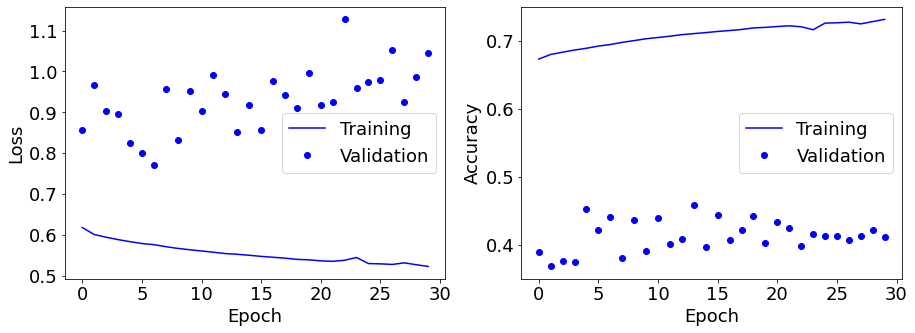

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


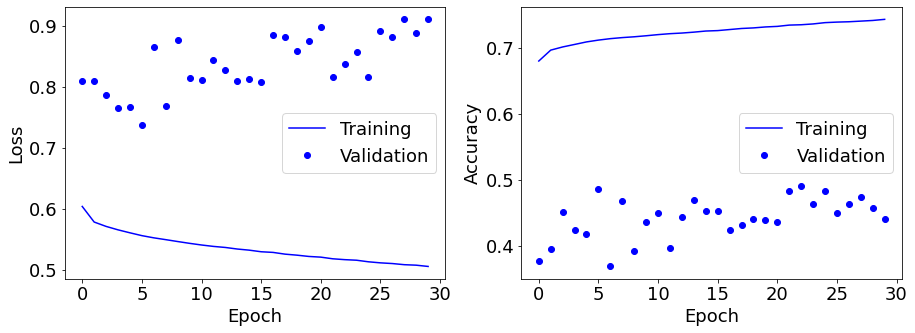

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


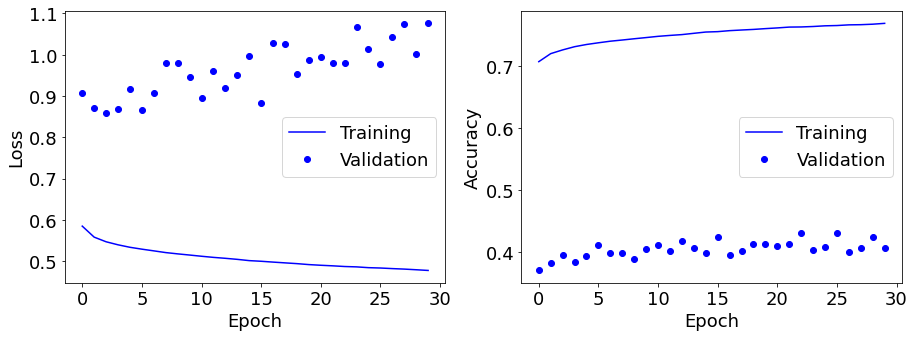

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


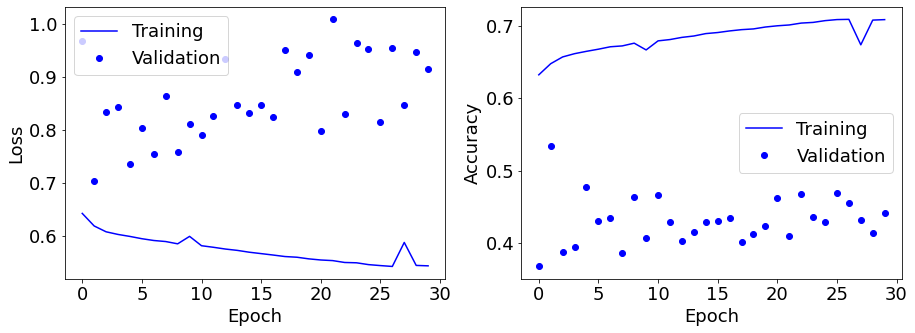

TRAINING
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


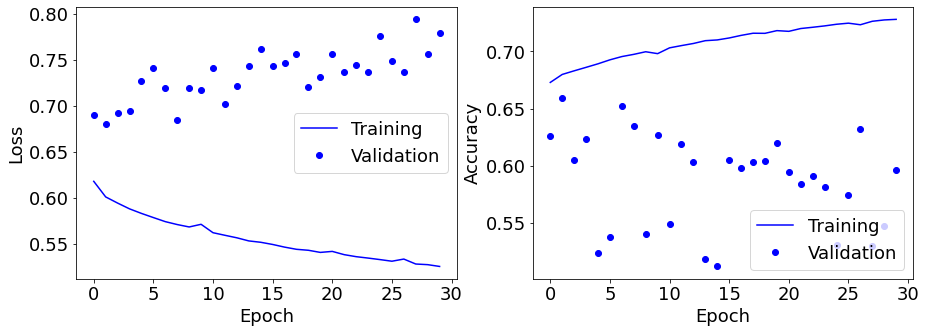

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


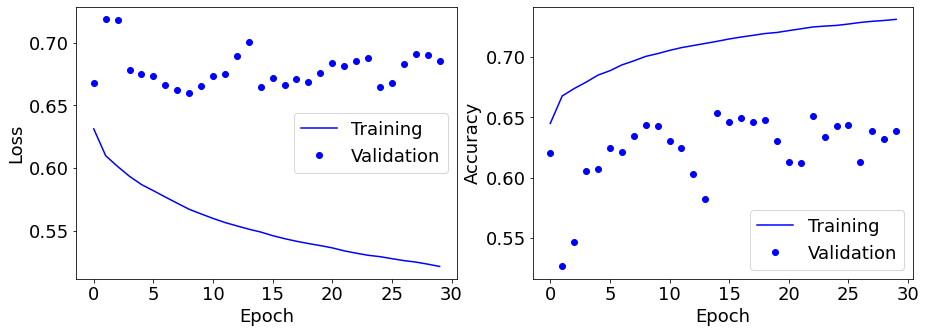

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


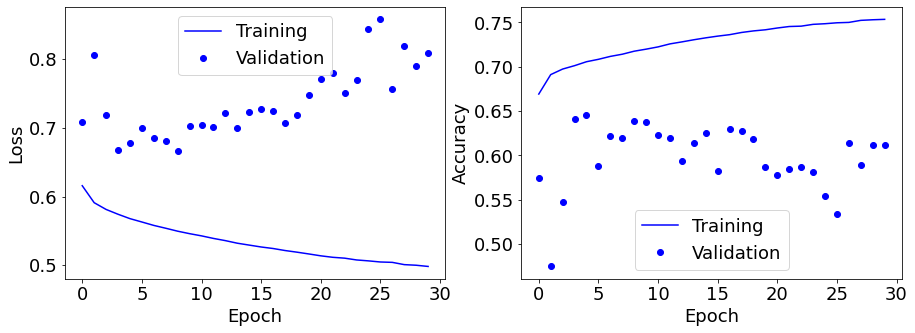

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


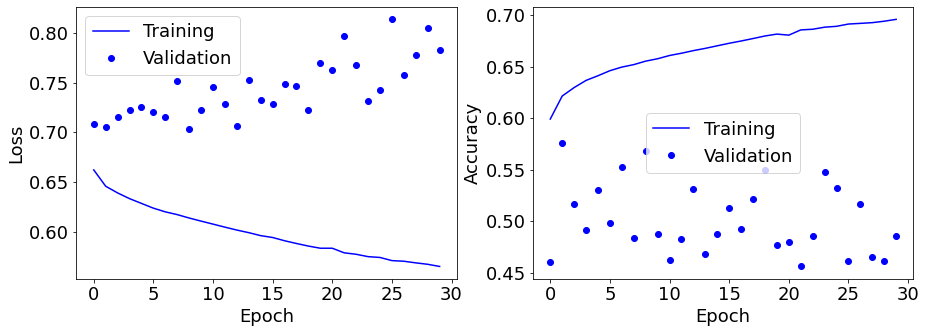

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


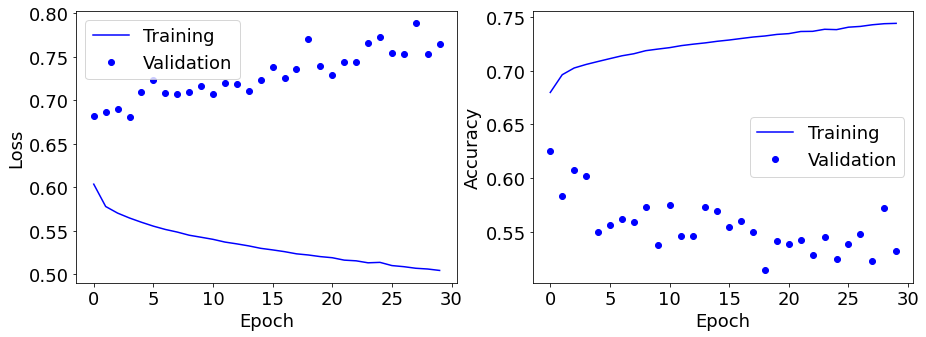

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


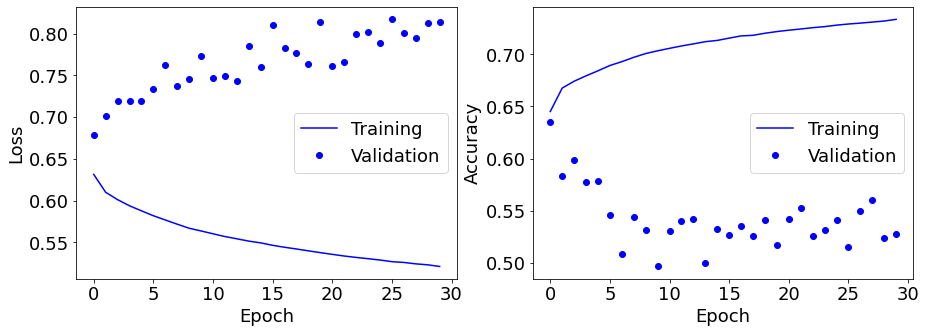

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


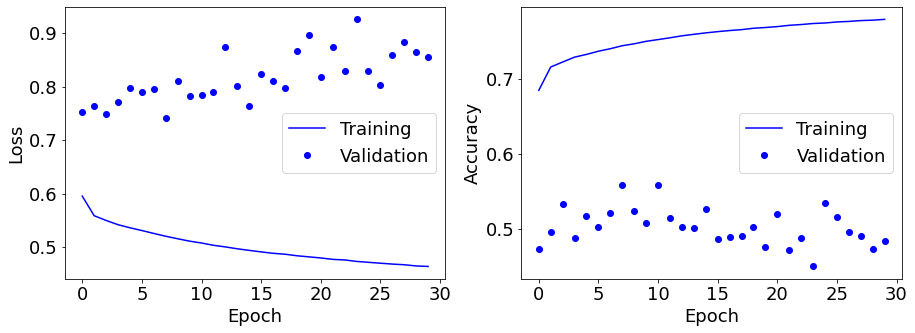

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


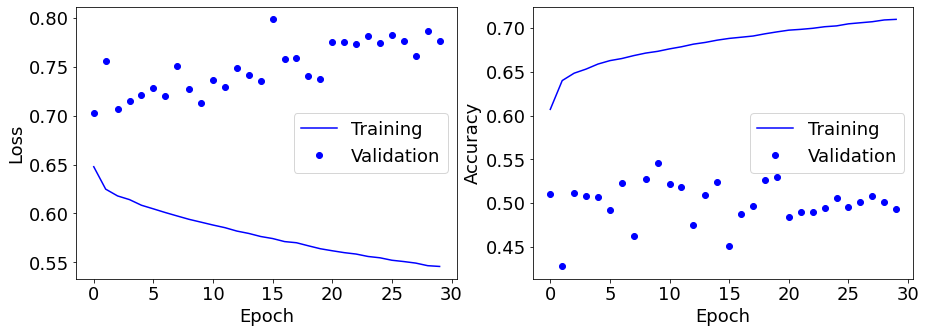

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


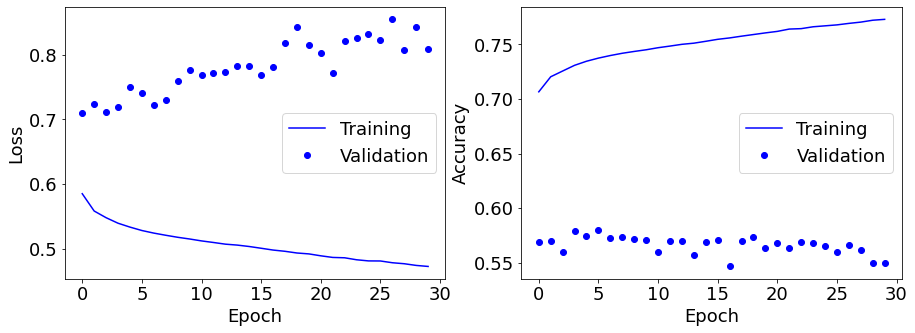

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


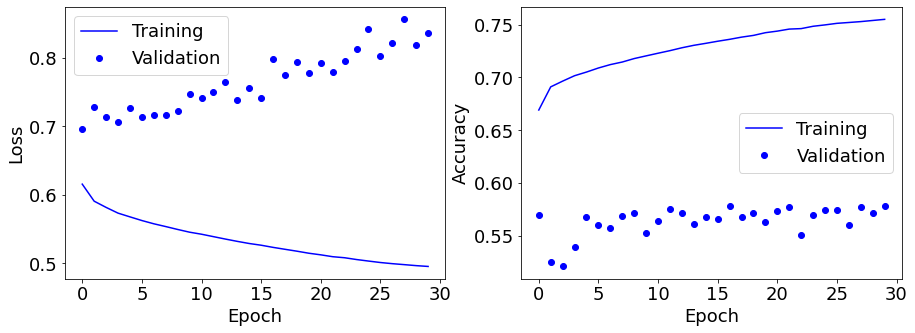

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]
VALIDATION
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


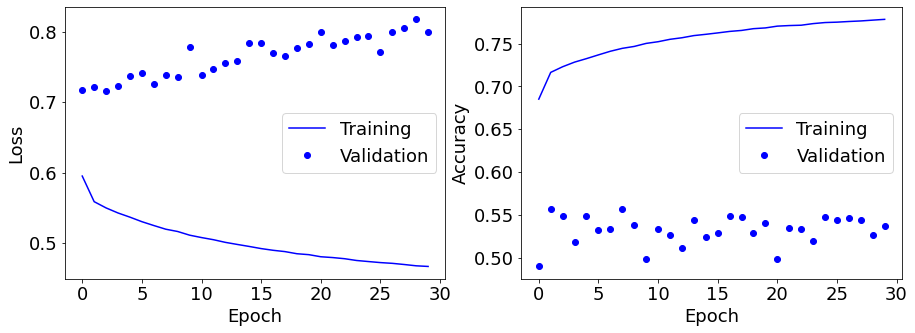

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
VALIDATION
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


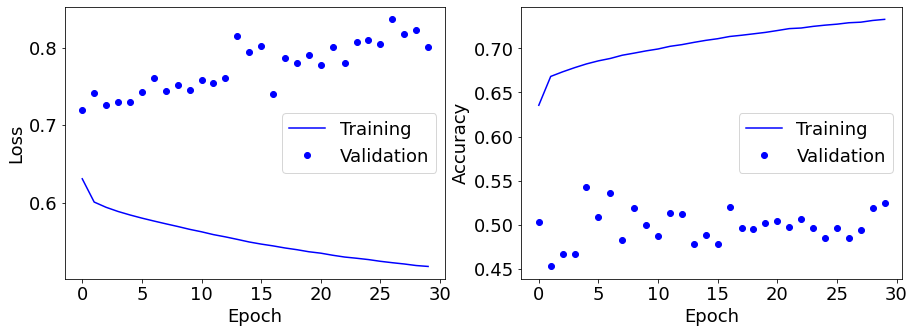

TRAINING
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


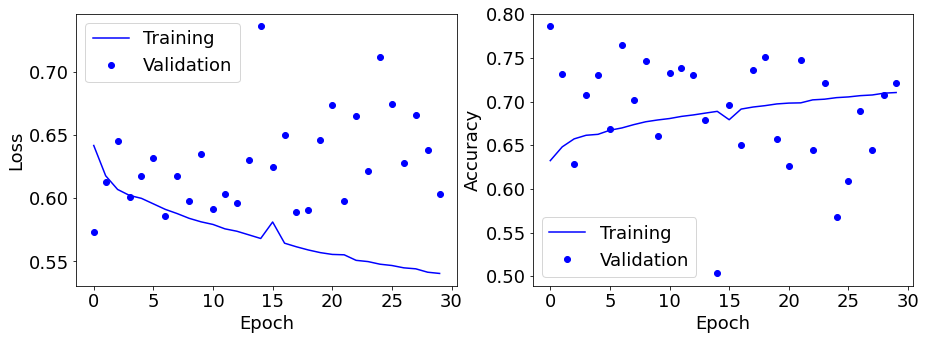

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


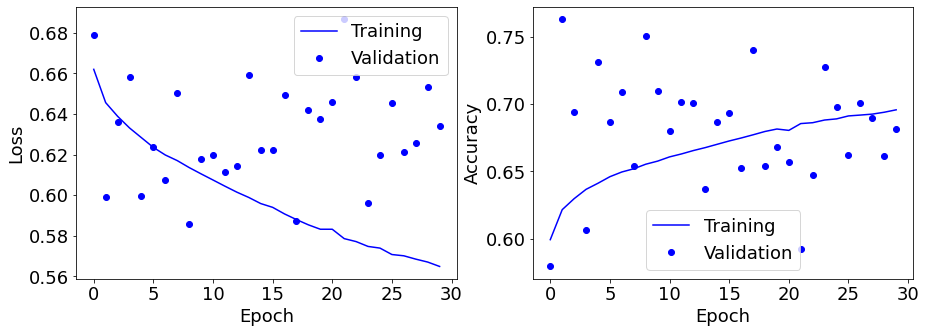

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 4
[13 10 14  8  2 11 12  5  1  6  4  3  9  7  0]
VALIDATION
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


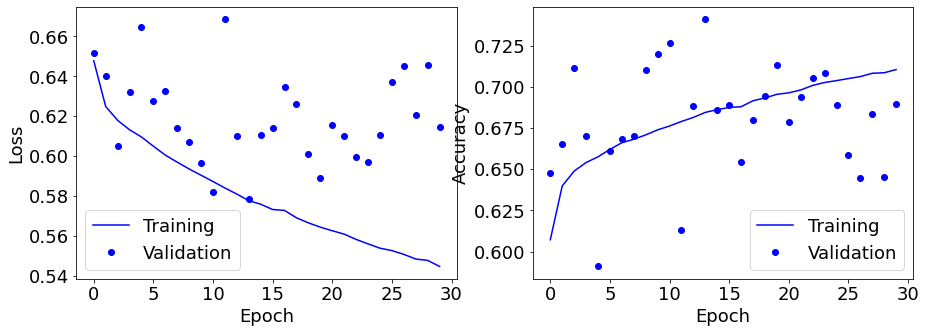

TRAINING
Mouse 1
[ 0  4  5  7  8  9  3  1  6 10  2]
Mouse 2
[ 4  7  5  2  3 10  8  6 11  9  1  0]
Mouse 3
[ 5 10 12  8  6  9 11  2  3  7  1  4 13  0]
VALIDATION
Mouse 5
[ 7  8  1  4  9  6  2 11  0  5 10  3]


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


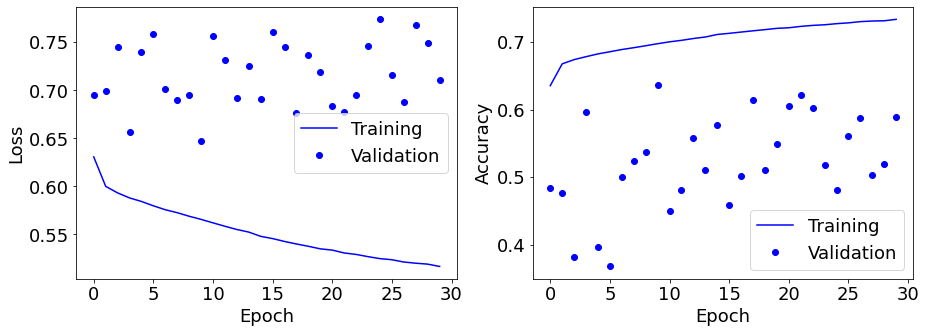

In [13]:
import itertools
l = [1, 2, 3, 4, 5]
for v in itertools.permutations(l, 2):
    TRAIN = [i for i in l if i not in v]
    VALID = [v[0]]
    TEST = [v[1]]
    trainX, validX, trainY, validY = Get_Dataset(TRAIN, VALID, TEST)
    for ModelType in Models:
        ver = f'{ModelType}_{VALID}_{TEST}_null'
        history = Learn_model(trainX, validX, trainY, validY, ModelType, ver)
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        ax[0].plot(epochs, loss, 'b', label='Training')
        ax[0].plot(epochs, val_loss, 'bo', label='Validation')
        ax[0].set(xlabel="Epoch")
        ax[0].set(ylabel="Loss")
        ax[0].legend()
        ax[1].plot(epochs, acc, 'b', label='Training')
        ax[1].plot(epochs, val_acc, 'bo', label='Validation')
        ax[1].set(xlabel="Epoch")
        ax[1].set(ylabel="Accuracy")
        ax[1].legend()
        plt.show()